In [905]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.utils import resample
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D, Dropout, Cropping2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import matplotlib.image as mpimg
import cv2
import pandas as pd
import ntpath
import random


In [906]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("No GPU devices found. Make sure you have installed the GPU version of TensorFlow.")
else:
    print("GPU devices found:", physical_devices)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


GPU devices found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [907]:
datadir = 'TrainingData'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
#print(data.head())
print(data['center'][0])

C:\Users\samto\Desktop\TrainingData\IMG\center_2024_01_14_15_58_23_672.jpg


In [908]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

In [909]:
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
print(data['center'][0])

center_2024_01_14_15_58_23_672.jpg


Visualization and distribution of data

In [910]:
num_bins = 31
samples_per_bin = 2500
hist, bins = np.histogram(data['steering'], num_bins)
print(bins)

[-0.9903171  -0.92611332 -0.86190955 -0.79770577 -0.73350199 -0.66929821
 -0.60509444 -0.54089066 -0.47668688 -0.4124831  -0.34827933 -0.28407555
 -0.21987177 -0.15566799 -0.09146422 -0.02726044  0.03694334  0.10114712
  0.16535089  0.22955467  0.29375845  0.35796223  0.422166    0.48636978
  0.55057356  0.61477734  0.67898111  0.74318489  0.80738867  0.87159245
  0.93579622  1.        ]


Length of data: 26892


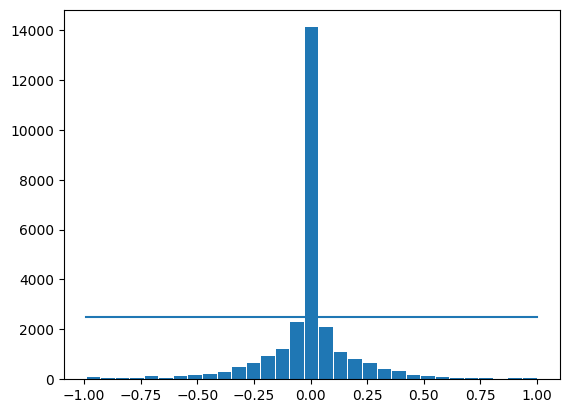

In [911]:
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width = 0.06)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
print("Length of data:" , len(data))

Removing Redundent Data

In [912]:
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j + 1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print("Removing: ", len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print("Length of remaining data:" , len(data))

Removing:  11609
Length of remaining data: 15283


Text(0.5, 1.0, 'Histogram of steering angles')

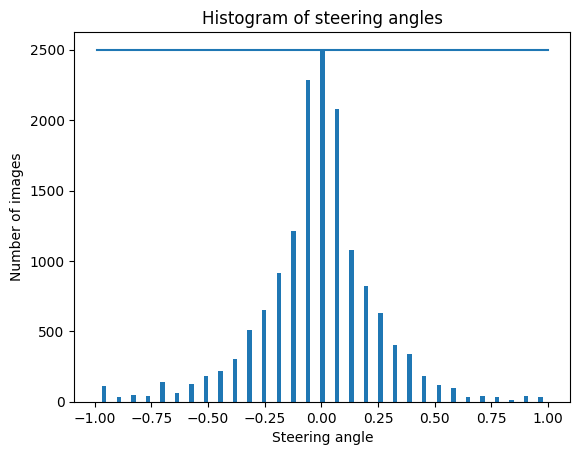

In [913]:
# Plot histogram

hist, bins = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width = 0.02)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.xlabel('Steering angle')
plt.ylabel('Number of images')
plt.title("Histogram of steering angles")

Load Data - Training and Validation Split

In [914]:
print(data.iloc[1])
def load_img_steering(datadir, df):
    image_paths = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path = os.path.join(datadir, center.strip())
        if os.path.isfile(image_path):
            image_paths.append(image_path)
            steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_paths)
    steering = np.asarray(steering)
    return image_paths, steering

center      center_2024_01_14_15_58_23_740.jpg
left          left_2024_01_14_15_58_23_740.jpg
right        right_2024_01_14_15_58_23_740.jpg
steering                             -0.370612
throttle                              0.525539
reverse                                    0.0
speed                                 22.71912
Name: 1, dtype: object


In [915]:
image_paths, steering = load_img_steering(datadir +"/IMG", data)
print(image_paths[0], steering[0])

C:\Users\samto\AppData\Local\Temp\ipykernel_12188\794695134.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
C:\Users\samto\AppData\Local\Temp\ipykernel_12188\794695134.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]))


TrainingData/IMG\center_2024_01_14_15_58_23_672.jpg -0.3706124


Balance Data

In [916]:
#focuses on steering when distributed randomly
rounded_steering = np.round(steering)  # Round steering angles
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering, test_size=0.2, random_state=6, stratify=rounded_steering)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 12226
Valid Samples: 3057


Text(0.5, 1.0, 'Validation set')

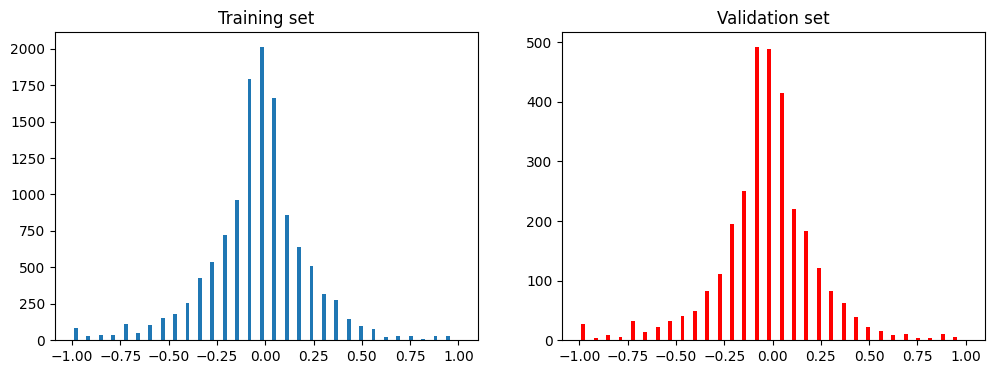

In [917]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.02)
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.02, color='r')
axes[1].set_title('Validation set')

Data Augmentation 

In [918]:
def augmentImage(imgPath, steering):
    img = mpimg.imread(imgPath)
    
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.2, 1.2))
        img = brightness.augment_image(img)
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = -steering
    if np.random.rand() < 0.5:
        shadow = iaa.AdditiveGaussianNoise(scale=0.1)
        img = shadow.augment_image(img)
    if np.random.rand() < 0.5:
        rotation = iaa.Affine(rotate=(-10, 10))
        img = rotation.augment_image(img)
    return img, steering
    

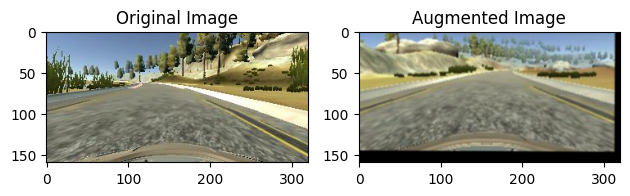

In [919]:
image = mpimg.imread(image_paths[1000])
imgRe, steerRe = augmentImage(image_paths[100], steering[100])

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(imgRe)
plt.title('Augmented Image')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

Preprocessing

In [920]:
def preProcessing(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (150, 50))
    img = img / 255
    return img

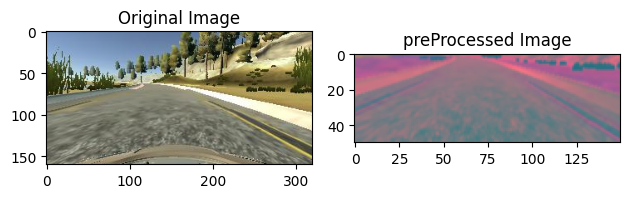

In [921]:
preProcessedImg = preProcessing(mpimg.imread(image_paths[3000]))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(preProcessedImg)
plt.title('preProcessed Image')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

In [922]:
def apply_recovery(image, steering):
    recovery_factor = 1.5
    steering_correction = recovery_factor * steering
    recovered_steering = steering - steering_correction
    return image, recovered_steering


In [923]:
def batchGen(imagesPath, steeringList, batchSize, trainFlag, recoveryFlag):
    while True:
        imgBatch = []
        steeringBatch = []
        for i in range(batchSize):
            index = random.randint(0, len(imagesPath) - 1)
            if trainFlag:
                img, steering = augmentImage(imagesPath[index], steeringList[index])
                if recoveryFlag and np.abs(steering) > 0.3:
                    img, steering = apply_recovery(img, steering)
            else:
                img = mpimg.imread(imagesPath[index])
                steering = steeringList[index]
            img = preProcessing(img)
            imgBatch.append(img)
            steeringBatch.append(steering)
        yield (np.asarray(imgBatch), np.asarray(steeringBatch))

Create Model

In [924]:
def createModel():
    model = Sequential()
    model.add(Convolution2D(24, kernel_size=(5, 5), strides=(2, 2), input_shape=(50, 150, 3), activation='relu'))
    model.add(Convolution2D(36, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
    model.add(Convolution2D(48, kernel_size=(5, 5), strides=(1, 1), activation='elu'))
    model.add(Convolution2D(64, kernel_size=(3, 3), activation='elu'))
    model.add(Convolution2D(64, kernel_size=(3, 3), activation='elu'))
    
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [925]:
model = createModel()
model.summary()


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_167 (Conv2D)         (None, 23, 73, 24)        1824      
                                                                 
 conv2d_168 (Conv2D)         (None, 10, 35, 36)        21636     
                                                                 
 conv2d_169 (Conv2D)         (None, 6, 31, 48)         43248     
                                                                 
 conv2d_170 (Conv2D)         (None, 4, 29, 64)         27712     
                                                                 
 conv2d_171 (Conv2D)         (None, 2, 27, 64)         36928     
                                                                 
 flatten_28 (Flatten)        (None, 3456)              0         
                                                                 
 dense_107 (Dense)           (None, 100)             

Training

In [926]:
def lr_schedule(epoch):
    return 0.0001 * 0.95 ** epoch


optimizer = Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=optimizer)

In [927]:
model.fit(batchGen(X_train, y_train, batchSize=64, trainFlag=1, recoveryFlag=1),
          steps_per_epoch=60,
          epochs=20,
          validation_data=batchGen(X_valid, y_valid, 200, 0, 0),
          validation_steps=len(X_valid) // 100,
          verbose=1,
          shuffle=1,
          #callbacks=[LearningRateScheduler(lr_schedule)]
          )

Epoch 1/20


60/60 [==============================] - 26s 432ms/step - loss: 0.0501 - val_loss: 0.0684
Epoch 2/20
60/60 [==============================] - 24s 415ms/step - loss: 0.0257 - val_loss: 0.0770
Epoch 3/20
60/60 [==============================] - 25s 416ms/step - loss: 0.0256 - val_loss: 0.0745
Epoch 4/20
60/60 [==============================] - 25s 423ms/step - loss: 0.0256 - val_loss: 0.0756
Epoch 5/20
60/60 [==============================] - 25s 422ms/step - loss: 0.0258 - val_loss: 0.0758
Epoch 6/20
60/60 [==============================] - 25s 421ms/step - loss: 0.0260 - val_loss: 0.0729
Epoch 7/20
60/60 [==============================] - 25s 417ms/step - loss: 0.0262 - val_loss: 0.0730
Epoch 8/20
60/60 [==============================] - 25s 419ms/step - loss: 0.0260 - val_loss: 0.0753
Epoch 9/20
60/60 [==============================] - 25s 418ms/step - loss: 0.0246 - val_loss: 0.0717
Epoch 10/20
60/60 [==============================] - 25s 422ms/step - loss: 0.0253 - val_loss: 0.0702


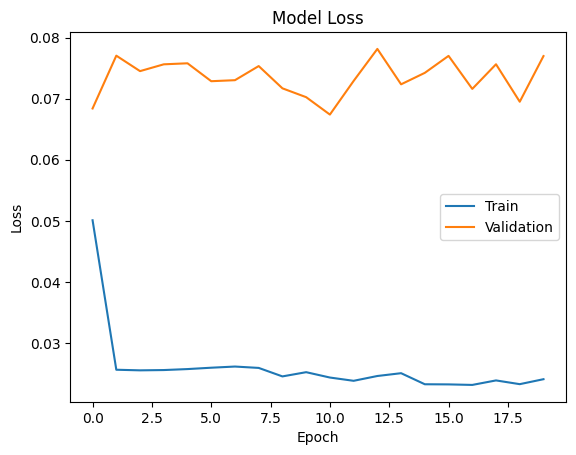

In [928]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()


In [929]:
model.save('modeltest.h5')

model 1
- Recorded 5 laps in each direction
- Works on most parts of the track 1 except for the first sharp bend
- Ran with only 5 epochs
- Added callback feature to end training when loss stops reducing 

model 2 
- Works on Track 1 
- Made it all aorund the map on max speed, but is close to edge at points
- Ran with 15 epochs
- Removed callback feature...
- Reduced the input size of images to speed up processing (150, 50 )
- Added Shadow to data augmentation
- Added Recovery Code

model 3 
- Works on Track 1 
- trying to generalise for track 2
- Ran with only 5 epochs
- Recorded 5 more laps in each direction
- Added Extra Recorded Data (start from the edge then drove to the center)
- Added Track 2 Data


